# Embedding for Sentiment Analysis 

Now that we know how word embedding works, we'll apply it to a supervised problem of sentiment analysis. The idea is to classify the comments left by users according to the number of stars they gave the Disneyland resort park in their reviews.

## Data Preprocessing

### Import Data 

1. Import the following libraries:

* tensorflow 
* pathlib
* pandas 
* os
* io

In [ ]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')

2. Copy the link below and read the file it contains with `pandas`.

* https://go.aws/314bBDq

In [ ]:
# Import dataset with Pandas 
dataset = pd.read_csv("https://go.aws/314bBDq", error_bad_lines=False, encoding="utf-8")
dataset.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
1,e3be4f9c9e0b9572bfb2a5f88497bb14,NaN,2,2017-09-29 17:29:00,17:29,17,Ven,NaN,NaN,2017-09,0,0
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
3,fa330e5891a1bb486c3e9bf95c098726,NaN,5,2017-09-29 15:52:00,15:52,15,Ven,NaN,NaN,2017-09,0,0
4,c1a693206aee1a2412d4bd9e45b80ec5,NaN,3,2017-09-29 15:29:00,15:29,15,Ven,NaN,NaN,2017-09,0,0


3. We will need the reviews in French. Filter the reviews so that they are in the right language. For this you need to find a column that gives you that information.

In [ ]:
# Taking only french reviews
french_reviews = dataset[dataset.review_lang == "french"]
french_reviews.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
11,726b1a3e2664e8b075129bcd643dbf56,En vacances en région parisienne nous nous som...,2,2017-09-29 00:37:00,00:37,0,Ven,en vacances en région parisienne nous nous som...,french,2017-09,172,25
12,8a71763fbb3da7436b957681b24cc404,Tropbeaufinalpleinlesyeuxoreil,5,2017-09-29 00:16:00,00:16,0,Ven,tropbeaufinalpleinlesyeuxoreil,french,2017-09,30,1
23,ce7abd7798ee036d667c0ad84b85daa7,L'univers Disney reste merveilleux. Toutefois ...,4,2017-09-28 20:24:00,20:24,20,Jeu,l univers disney reste merveilleux toutefois ...,french,2017-09,148,23


4. Keep only the `review_format` & `stars` columns.

In [ ]:
# Let's take the columns we're interested in 
french_reviews = french_reviews[["review_format", "stars"]]
french_reviews.head()

,review_format,stars
0,génial fabuleux exceptionnel j aimerais qu...,5
2,toujours aussi magic féerique,5
11,en vacances en région parisienne nous nous som...,2
12,tropbeaufinalpleinlesyeuxoreil,5
23,l univers disney reste merveilleux toutefois ...,4


### Preprocessing

We will now go through a preprocessing phase. The goal is to clean up the character strings and encode the words so they are represented as integers.

1. Use the command: `!python -m spacy download fr_core_news_sm` to download all language elements related to the French language

In [ ]:
!python -m spacy download fr_core_news_md -q

     |████████████████████████████████| 88.6 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


2. Load now `fr_core_news_sm`

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

In [ ]:
# Import Spacy and french initialisation
import fr_core_news_md
nlp = fr_core_news_md.load()

3. Import french STOP_WORDS

In [ ]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

In [ ]:
a = nlp("je laisse laisser laissée laissé")

In [ ]:
[element.lemma_ for element in a]

['je', 'laisse', 'laisser', 'laisser', 'laisser']

4. You will now have to clean our texts in order to prepare them for training.
Let's do this in three different steps :
 * using the command `str.isalnum` remove all characters from your strings that are not alphanumeric except for whitespaces.
 * using `str.replace`, `str.lower` and `str.strip` replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
 * using spacy, replace all tokens in your texts with `lemma_` and remove all the stop words.

In [ ]:
x = 'eeeje123@dd'
''.join(ch for ch in x if ch.isalnum() or ch==" ")

'eeeje123dd'

In [ ]:
french_reviews["review_format_clean"] = french_reviews["review_format"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
french_reviews["review_format_clean"] = french_reviews["review_format_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
french_reviews["review_format_clean"] = french_reviews["review_format_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

french_reviews

,review_format,stars,review_format_clean
0,génial fabuleux exceptionnel j aimerais qu...,5,génial fabuleux exceptionnel j aimer wa...
2,toujours aussi magic féerique,5,magic féerique
11,en vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...
12,tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil
23,l univers disney reste merveilleux toutefois ...,4,l univers disney merveilleux regrette qu fal...
...,...,...,...
295057,toujours aussi magique même si à la fin du séj...,5,magique fin séjour rotule lol
295549,séjour au top mes enfants les plus heureux ...,5,séjour top enfant heureux vouloir voir per...
298475,magnifique un monde parfait lt,5,magnifique monde parfait lt
298832,oui j ai aimé car j adore disney et tout ce qu...,4,oui j aimer j adore disney touche univers ...


5. Using `tf.keras.preprocessing.text.Tokenizer` [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer), process to encoding all the reviews (be careful, some reviews might have been entirely erased, try and understand why, remove those reviews)

When instanciating the tokenizer, make sure you set it up to keep only the 1000 most common words.

In [ ]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(french_reviews.review_format_clean)
french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews.review_format_clean)
french_reviews["len_review"] = french_reviews["review_encoded"].apply(lambda x: len(x))
french_reviews = french_reviews[french_reviews["len_review"]!=0]

In [ ]:
french_reviews.head()

,review_format,stars,review_format_clean,review_encoded,len_review
0,génial fabuleux exceptionnel j aimerais qu...,5,génial fabuleux exceptionnel j aimer wa...,"[89, 509, 439, 6, 164, 400, 8]",7
2,toujours aussi magic féerique,5,magic féerique,"[295, 58]",2
11,en vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...,"[363, 763, 426, 5, 313, 111, 5, 107, 30, 1, 10]",11
23,l univers disney reste merveilleux toutefois ...,4,l univers disney merveilleux regrette qu fal...,"[4, 337, 8, 79, 615, 22, 51, 94, 138, 945, 92,...",14
29,nous avons passé jours dans les parcs et nu...,4,jour parc nuire l hôtel santafé excell...,"[26, 5, 986, 4, 42, 124, 47, 4, 337, 8, 83, 74...",67


6. Try and convert your texts and labels into a tensor slice dataset using `tf.data.Dataset.from_tensor_slices` (it should fail giving this error : `ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list)`.)




In [ ]:
full_ds = tf.data.Dataset.from_tensor_slices((french_reviews.review_encoded, french_reviews.stars.values-1))

ValueError: ignored

7. This is perfectly normal, Tensorflow is incapable as of now to create a tensor dataset based on lists, we will have to store all of our encoded texts into a single numpy array before creating the tensorflow dataset.
The problem is that not all our sequences are the same length, this is where the `tf.keras.preprocessing.sequence.pad_sequences` comes in handy, it will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of your sequences so they all have equal length.

In [ ]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(french_reviews.review_encoded, padding="post")

8. Now that your sequences are padded create the tensor dataset. Make sure you modify the stars column so that the scores go from 0 to 4 instead of 1 to 5 to avoid errors when setting up your model's architecture and the loss function. (Since this is a multiple classification problem, we will use SparseCategoricalCrossentropy which assumes that the first label is 0)

In [ ]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, french_reviews.stars.values-1))

9. Do a `train_test_split` of your data (keep about 70% in the train). For this you may use the `.take` and `.skip` methods on the tensorflow dataset.
Once you have done this you may use `.shuffle` on the train set, and `.batch`on both sets to organise them by batches of 64 observations.

* [take documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)

* [skip documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip)

* [shuffle documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)

* [batch documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)



In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*french_reviews.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

10. Look at a batch of data 

In [ ]:
 # Regardons un batch 
for review, star in train_data.take(1):
  print(review, star)

tf.Tensor(
[[ 46  83  43 ...   0   0   0]
 [  9 102 679 ...   0   0   0]
 [  5 149  58 ...   0   0   0]
 ...
 [  1 169  41 ...   0   0   0]
 [  9   1 169 ...   0   0   0]
 [100 219  25 ...   0   0   0]], shape=(64, 179), dtype=int32) tf.Tensor(
[3 4 4 3 1 2 4 4 3 4 4 4 4 4 4 4 4 3 4 0 3 4 4 3 2 4 3 4 2 4 4 4 4 4 1 1 4
 4 4 3 3 4 4 4 2 4 4 2 4 2 3 4 2 4 4 3 2 4 4 4 0 4 4 3], shape=(64,), dtype=int64)


## Modeling

Let's create a model in order to train an embedding!

1. Follow a similar architecture to the one we used in the code embedding demonstration.

1000

In [ ]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 179, 8)            8008      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 8,297
Trainable params: 8,297
Non-trainable params: 0
_________________________________________________________________


2. Compile your model with the correct loss function, and the Adam optimizer.

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

3. Using the pandas function `.value_counts` create a dictionnary that assigns to each value of the target variable a weight that is inversely proportionnal to their frequency in the dataset.

In [ ]:
weights = dict(1/(french_reviews.stars-1).value_counts()/sum(1/(french_reviews.stars-1).value_counts())*5)
weights

{0: 1.5721371987602364,
 1: 1.8050464133913828,
 2: 0.870290235027988,
 3: 0.5715000370737537,
 4: 0.18102611574663888}

4. Fit your model on 20 epochs with weights to penalize too frequent notes. 

In [ ]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data)

Epoch 1/20
93/93 [==============================] - 1s 7ms/step - loss: 9.0141 - mean_absolute_error: 2.7846 - val_loss: 6.5664 - val_mean_absolute_error: 2.3924
Epoch 2/20
93/93 [==============================] - 1s 6ms/step - loss: 2.5384 - mean_absolute_error: 1.3651 - val_loss: 1.6081 - val_mean_absolute_error: 1.0237
Epoch 3/20
93/93 [==============================] - 1s 6ms/step - loss: 1.3298 - mean_absolute_error: 0.9219 - val_loss: 1.5701 - val_mean_absolute_error: 1.0242
Epoch 4/20
93/93 [==============================] - 1s 6ms/step - loss: 1.2899 - mean_absolute_error: 0.9057 - val_loss: 1.5271 - val_mean_absolute_error: 1.0036
Epoch 5/20
93/93 [==============================] - 1s 6ms/step - loss: 1.2562 - mean_absolute_error: 0.8946 - val_loss: 1.4829 - val_mean_absolute_error: 0.9737
Epoch 6/20
93/93 [==============================] - 1s 6ms/step - loss: 1.2260 - mean_absolute_error: 0.8814 - val_loss: 1.4577 - val_mean_absolute_error: 0.9791
Epoch 7/20
93/93 [==========

## Evaluation 

1. Create a graph showing your loss in relation to the number of epochs.

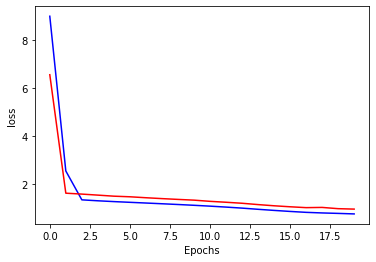

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

2. Create a graph showing your accuracy in relation to the number of epochs.

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

KeyError: ignored

3. Write to file the weights on the embedding layer and the 1000 most common words registered by the tokenizer. You can help yourself to the code in the code embedding demonstration.

In [ ]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "/content/logs/embed"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

4. Go to [the embedding projector](https://projector.tensorflow.org/) in order to visualize the embedding, what do you think?

In [ ]:
history_dict = history.history
print(history_dict.keys())